https://youtu.be/83tnWs_YBRQ

In [1]:
# # Install the required libraries
# #SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
# #Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
# #Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
# #Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

^C
  Cloning https://github.com/facebookresearch/segment-anything.git to c:\users\evdra\appdata\local\temp\pip-req-build-2ya_wo7_
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git 'C:\Users\evdra\AppData\Local\Temp\pip-req-build-2ya_wo7_'


  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.4.1
    Uninstalling numpy-2.4.1:
      Successfully uninstalled numpy-2.4.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.13.0.90 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [ ]:
# !pip uninstall -y numpy



In [3]:
# !pip install numpy==2.0.2

!pip install albumentations

  Using cached albumentations-2.0.8-py3-none-any.whl.metadata (43 kB)
  Using cached albucore-0.0.24-py3-none-any.whl.metadata (5.3 kB)
  Using cached opencv_python_headless-4.13.0.90-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached numpy-2.4.1-cp311-cp311-win_amd64.whl.metadata (6.6 kB)
Using cached albumentations-2.0.8-py3-none-any.whl (369 kB)
Using cached albucore-0.0.24-py3-none-any.whl (15 kB)
Using cached opencv_python_headless-4.13.0.90-cp37-abi3-win_amd64.whl (40.1 MB)
Using cached numpy-2.4.1-cp311-cp311-win_amd64.whl (12.6 MB)

  Attempting uninstall: numpy

    Found existing installation: numpy 1.26.4

   ---------------------------------------- 0/4 [numpy]
    Uninstalling numpy-1.26.4:
   ---------------------------------------- 0/4 [numpy]
   ---------------------------------------- 0/4 [numpy]
   ---------------------------------------- 0/4 [numpy]
   ---------------------------------------- 0/4 [numpy]
      Successfully uninstalled numpy-1.26.4
   ------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
patchify 0.2.3 requires numpy<2,>=1, but you have numpy 2.4.1 which is incompatible.


In [5]:
import albumentations as A


i:\NSU\technohack\ovenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from PIL import Image
from tqdm import tqdm
from statistics import mean

from transformers import SamProcessor
from transformers import SamModel

from datasets import Dataset
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
from torch.nn.functional import threshold, normalize
import torch.nn.functional as F
from torch.optim import Adam


import monai




In [146]:
# patchesdir = '/content/drive/MyDrive/IT-Geo-Paleochannel/patches'
patchesdir = 'I:/NSU/technohack/patches'

images_train_dir = patchesdir + '/train/images'
masks_train_dir = patchesdir + '/train/masks'

image_train = sorted([f for f in os.listdir(images_train_dir) if f.endswith(".npy")])
mask_train = sorted([f for f in os.listdir(masks_train_dir) if f.endswith(".npy")])

dataset = {
    "image": [np.load(os.path.join(images_train_dir, f)) for f in image_train],
    "label": [np.load(os.path.join(masks_train_dir, f)) for f in mask_train],
}

print(f"Loaded {len(dataset['image'])} images and {len(dataset['label'])} masks")


Loaded 119 images and 119 masks


In [147]:

images_val_dir = patchesdir + '/val/images'
masks_val_dir = patchesdir + '/val/masks'

image_val = sorted([f for f in os.listdir(images_val_dir) if f.endswith(".npy")])
mask_val = sorted([f for f in os.listdir(masks_val_dir) if f.endswith(".npy")])

val = {
    "image": [np.load(os.path.join(images_val_dir, f)) for f in image_val],
    "label": [np.load(os.path.join(masks_val_dir, f)) for f in mask_val],
}

print(f"Loaded {len(val['image'])} images and {len(val['label'])} masks")


Loaded 20 images and 20 masks


Let us make sure out images and masks (labels) are loading appropriately

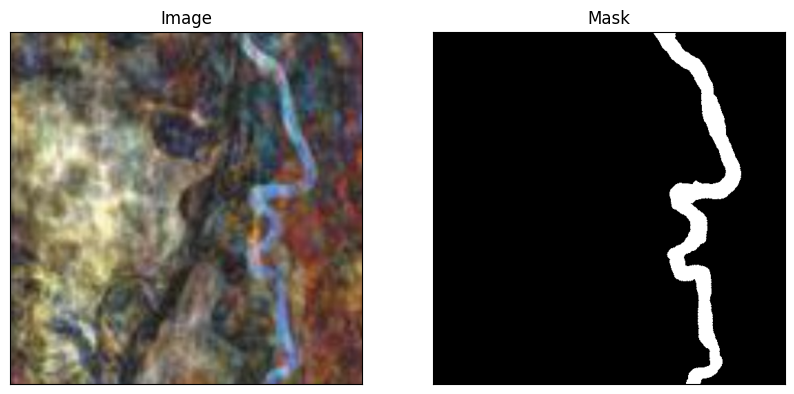

In [148]:
img_num = random.randint(0, len(image_train)-1)
example_image = dataset["image"][img_num]
example_mask = dataset["label"][img_num]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

Get bounding boxes from masks. You can get here directly if you are working with coco style annotations where bounding boxes are captured in a JSON file.

In [149]:
import numpy as np
import math

def get_random_points(ground_truth_map, n):
    y_indices, x_indices = np.where(ground_truth_map > 0)
    if len(x_indices) == 0 or len(y_indices) == 0:
        return []
    n_points = min(n, len(x_indices))
    random_indices = np.random.choice(len(x_indices), size=n_points, replace=False)
    height, width = ground_truth_map.shape
    final_points = []
    angles_deg = np.arange(0, 180, 30)
    angles_rad = np.radians(angles_deg)
    dirs = list(zip(np.sin(angles_rad), np.cos(angles_rad)))
    for idx in random_indices:
        start_x = x_indices[idx]
        start_y = y_indices[idx]
        min_len = float('inf')
        best_segment = None
        for dy, dx in dirs:
            dist_pos = 0
            cur_x, cur_y = start_x, start_y
            while True:
                next_x = cur_x + dx
                next_y = cur_y + dy
                ix, iy = int(round(next_x)), int(round(next_y))
                if 0 <= ix < width and 0 <= iy < height and ground_truth_map[iy, ix] > 0:
                    cur_x, cur_y = next_x, next_y
                    dist_pos += 1
                else:
                    break
            dist_neg = 0
            cur_x, cur_y = start_x, start_y
            while True:
                next_x = cur_x - dx
                next_y = cur_y - dy
                ix, iy = int(round(next_x)), int(round(next_y))
                if 0 <= ix < width and 0 <= iy < height and ground_truth_map[iy, ix] > 0:
                    cur_x, cur_y = next_x, next_y
                    dist_neg += 1
                else:
                    break
            total_len = dist_pos + dist_neg
            if total_len < min_len:
                min_len = total_len
                p1 = (start_y + dy * dist_pos, start_x + dx * dist_pos)
                p2 = (start_y - dy * dist_neg, start_x - dx * dist_neg)
                best_segment = (p1, p2)
        if best_segment is not None and min_len > 0:
            (y1, x1), (y2, x2) = best_segment
            mid_y = (y1 + y2) / 2
            mid_x = (x1 + x2) / 2
            sigma = min_len / 4.0
            if sigma == 0:
                final_points.append([int(start_x), int(start_y)])
                continue
            offset = np.random.normal(0, sigma)
            vec_y = y1 - y2
            vec_x = x1 - x2
            new_y = mid_y + (vec_y / min_len) * offset
            new_x = mid_x + (vec_x / min_len) * offset
            res_x = int(round(new_x))
            res_y = int(round(new_y))
            final_points.append([res_x, res_y])
        else:
            final_points.append([start_x, start_y])
    return final_points

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms.functional as TF
import albumentations as A

def fade(t):
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def lerp(a, b, t):
    return a + t * (b - a)

def gradient(h, x, y):
    vectors = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]])
    g = vectors[h % 4]
    return g[:, :, 0] * x + g[:, :, 1] * y

def perlin(x, y, seed=None):
    if seed is not None:
        np.random.seed(seed)
    else:
        np.random.seed(np.random.randint(0, 100000))
    
    p = np.arange(256, dtype=int)
    np.random.shuffle(p)
    p = np.stack([p, p]).flatten()
    
    xi = x.astype(int)
    yi = y.astype(int)
    xf = x - xi
    yf = y - yi
    
    u = fade(xf)
    v = fade(yf)
    
    n00 = gradient(p[p[xi] + yi], xf, yf)
    n01 = gradient(p[p[xi] + yi + 1], xf, yf - 1)
    n11 = gradient(p[p[xi + 1] + yi + 1], xf - 1, yf - 1)
    n10 = gradient(p[p[xi + 1] + yi], xf - 1, yf)
    
    x1 = lerp(n00, n10, u)
    x2 = lerp(n01, n11, u)
    return lerp(x1, x2, v)

class PerlinNoise(A.ImageOnlyTransform):
    def __init__(self, scale_range=(5, 20), alpha_range=(0.02, 0.1), always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.scale_range = scale_range
        self.alpha_range = alpha_range

    def apply(self, image, **params):
        scale = np.random.uniform(*self.scale_range)
        alpha = np.random.uniform(*self.alpha_range)
        h, w, c = image.shape
        noise = np.zeros((h, w, c))
        for i in range(c):
            xx = np.linspace(0, scale, w)
            yy = np.linspace(0, scale, h)
            x, y = np.meshgrid(xx, yy)
            noise[:, :, i] = perlin(x, y)
        image = image + noise * alpha
        image = np.clip(image, 0, 1)
        return image

class SAMDataset(Dataset):
    """
    This class is used to create a dataset that serves input images and masks.
    It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
    """
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.3),
            A.RandomRotate90(p=0.3),
            A.Rotate(limit=(0, 360), border_mode=0, value=(1, 1, 1), mask_value=0.0, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.1, p=0.4),
            A.GaussNoise(var_limit=(0.0016, 0.04), mean=0, per_channel=True, p=0.3),
            PerlinNoise(scale_range=(5, 20), alpha_range=(0.02, 0.1), p=0.3),
            A.GaussianBlur(blur_limit=(3, 7), p=0.2),
        ])

    def __len__(self):
        return len(self.dataset["image"])

    def __getitem__(self, idx):
        image = self.dataset["image"][idx].copy()
        ground_truth_mask = self.dataset["label"][idx].copy()

        # Приведение к стандартному виду (H, W, C) или (H, W)
        if image.ndim == 3 and image.shape[0] == 3:
            image = np.transpose(image, (1, 2, 0))

        if ground_truth_mask.ndim == 3 and ground_truth_mask.shape[0] == 1:
            ground_truth_mask = ground_truth_mask.squeeze(0)

        image = image.astype(np.float32)
        if np.max(image) > 1.0:
            image /= 255.0

        

        ground_truth_mask = (ground_truth_mask > 0).astype(np.float32)

        augmented = self.transform(image=image, mask=ground_truth_mask)
        image_np = augmented['image']  # (H, W, 3), [0, 1]
        mask_np = augmented['mask']    # (H, W)

        prompt = get_random_points(mask_np, 3)

        image_pil = Image.fromarray(np.clip(image_np * 255, 0, 255).astype(np.uint8))

        inputs = self.processor(image_pil, input_points=[[prompt]], return_tensors="pt", size={"longest_edge": 1024})
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        ground_truth_mask_tensor = torch.tensor(mask_np).unsqueeze(0)  # [1, H, W]
        H, W = inputs["pixel_values"].shape[1:]
        ground_truth_mask_tensor = TF.resize(
            ground_truth_mask_tensor,
            size=(H, W),
            interpolation=TF.InterpolationMode.NEAREST
        ).squeeze(0)
        inputs["ground_truth_mask"] = ground_truth_mask_tensor

        return inputs

In [164]:
def visualize_sam_example(example, image_idx=0):
    """
    Визуализирует изображение с точками промпта и маской
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    pixel_values = example["pixel_values"]  # [3, 1024, 1024]
    input_points = example["input_points"]  # [1, 3, 2]
    ground_truth_mask = example["ground_truth_mask"]  # [1, 512, 512]

    image = pixel_values.permute(1, 2, 0).cpu().numpy()  # [1024, 1024, 3]
    image = (image - image.min()) / (image.max() - image.min())

    # Выводим шейпы в заголовке
    image_shape = image.shape
    axes[0].imshow(image)

    points = input_points.squeeze(0).cpu().numpy()  # [3, 2]
    for i, (x, y) in enumerate(points):
        axes[0].scatter(x, y, c='red', s=50, marker='o', edgecolors='white', linewidths=1)
        axes[0].text(x, y, str(i+1), color='white', fontsize=12,
                    ha='center', va='center', fontweight='bold')
    axes[0].set_title(f"Image with {len(points)} points\nShape: {image_shape}")
    axes[0].axis('off')

    mask = ground_truth_mask.squeeze(0).cpu().numpy()  # [512, 512] вместо [1, 512, 512]
    mask_shape = mask.shape
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title(f"Ground Truth Mask\nShape: {mask_shape}")
    axes[1].axis('off')

    plt.suptitle(f"SAM Dataset Example {image_idx}", fontsize=14)
    plt.tight_layout()
    plt.show()

In [165]:
# Initialize the processor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")


In [167]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)
val_dataset = SAMDataset(dataset=val, processor=processor)

len of dataset is 2
len of dataset is 2


C:\Users\evdra\AppData\Local\Temp\ipykernel_8624\2061418035.py:79: UserWarning: Argument(s) 'value, mask_value' are not valid for transform Rotate
  A.Rotate(limit=(0, 360), border_mode=0, value=(1, 1, 1), mask_value=0.0, p=0.5),
C:\Users\evdra\AppData\Local\Temp\ipykernel_8624\2061418035.py:81: UserWarning: Argument(s) 'var_limit, mean' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(0.0016, 0.04), mean=0, per_channel=True, p=0.3),


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_points torch.Size([1, 3, 2])
ground_truth_mask torch.Size([1024, 1024])


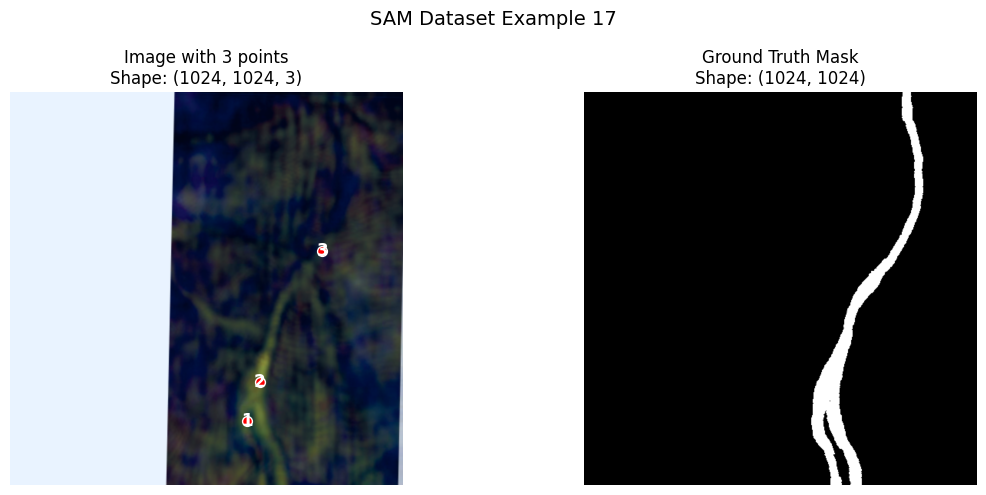

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_points torch.Size([1, 3, 2])
ground_truth_mask torch.Size([1024, 1024])


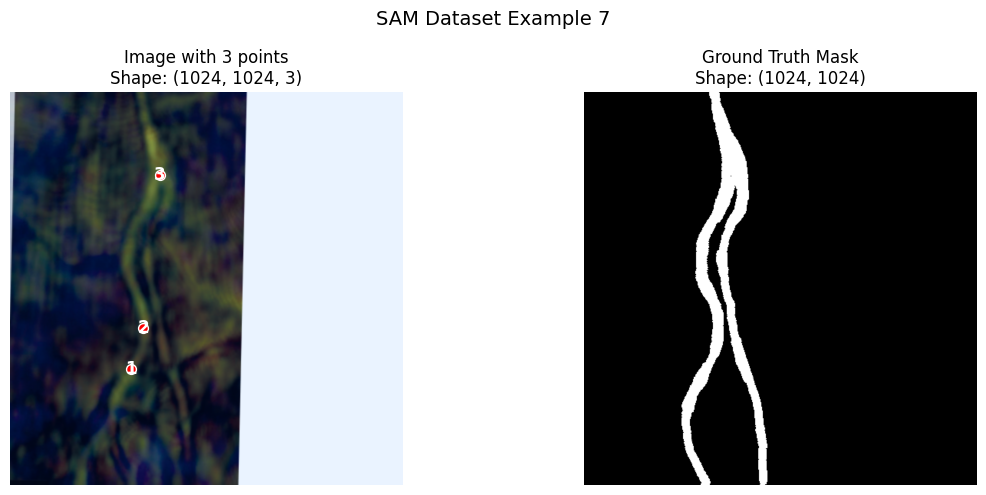

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_points torch.Size([1, 3, 2])
ground_truth_mask torch.Size([1024, 1024])


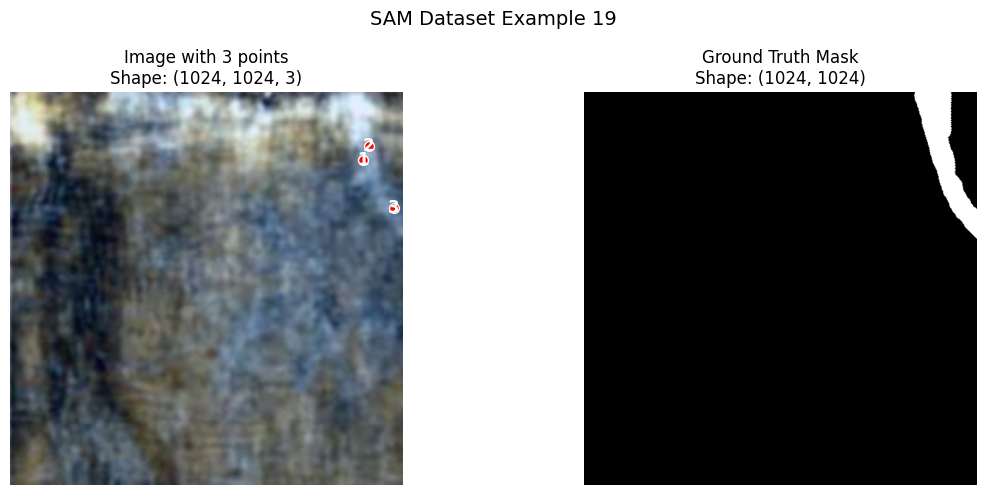

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_points torch.Size([1, 3, 2])
ground_truth_mask torch.Size([1024, 1024])


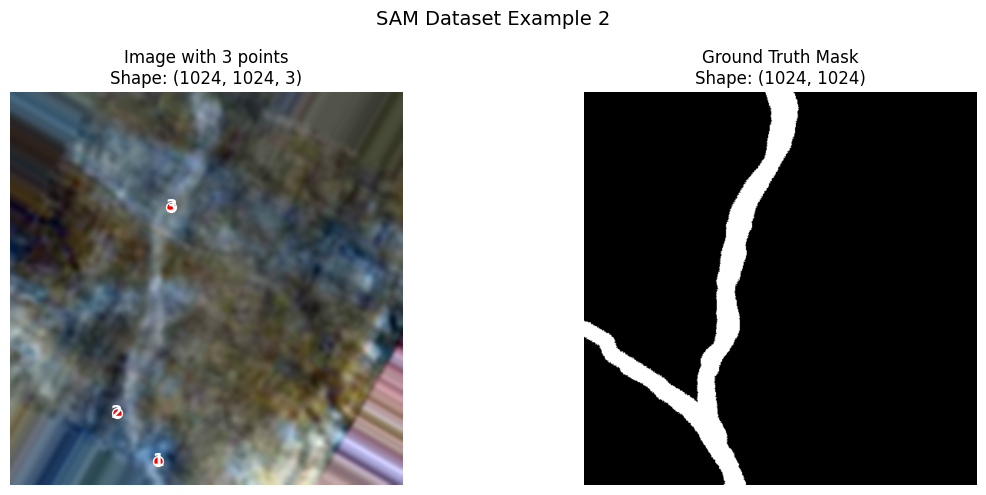

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_points torch.Size([1, 3, 2])
ground_truth_mask torch.Size([1024, 1024])


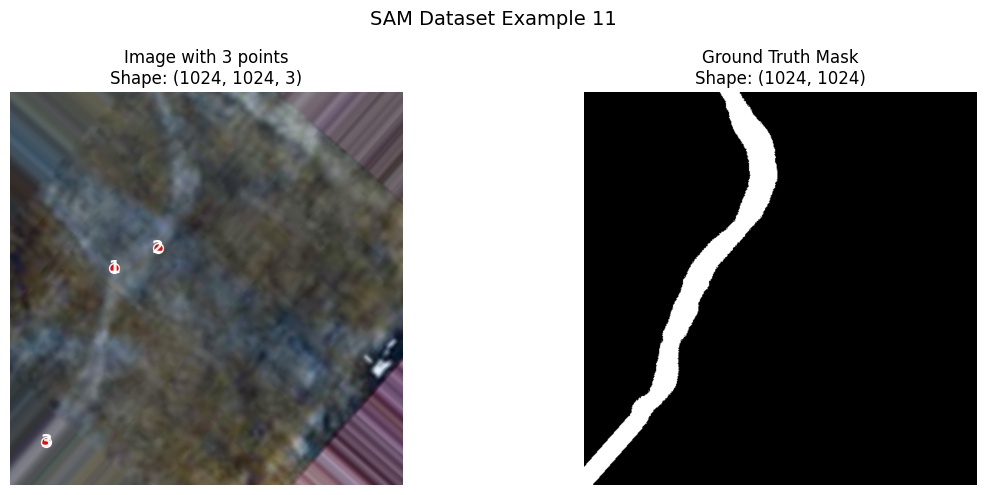

IndexError: index 0 is out of bounds for axis 1 with size 0

In [162]:
for i in range(len(train_dataset)):
  example = train_dataset[i]
  for k,v in example.items():
    print(k,v.shape)

  visualize_sam_example(example, image_idx=random.randint(1, 20))



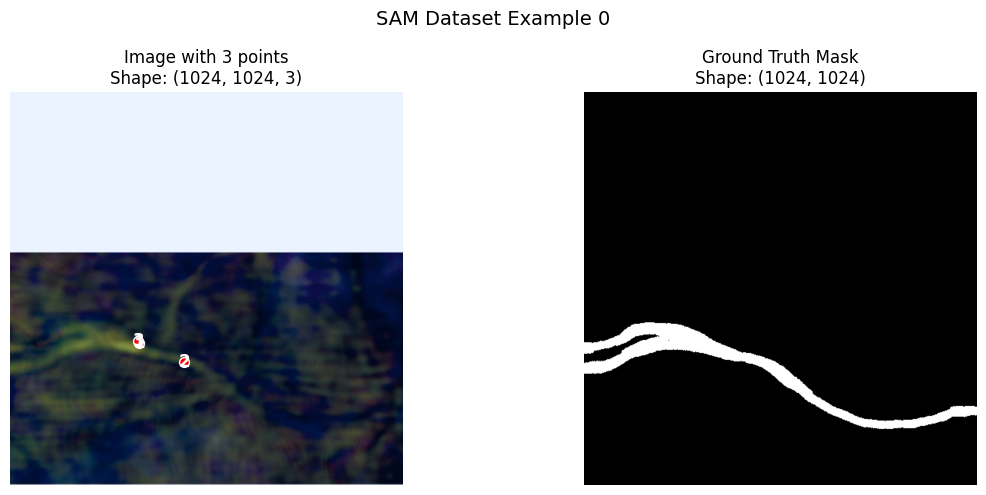

In [190]:
example = val_dataset[0]
for k,v in example.items():
  print(k,v.shape)


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_points torch.Size([1, 3, 2])
ground_truth_mask torch.Size([1024, 1024])


In [191]:
def plot_metrics(metrics):
    """
    Визуализирует метрики обучения модели
    """
    epochs = range(len(metrics["Train loss"]))

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    # Train Loss
    axes[0, 0].plot(epochs, metrics["Train loss"])
    axes[0, 0].set_title("Train Loss")
    axes[0, 0].set_xlabel("Epoch")

    # Val Loss
    axes[0, 1].plot(epochs, metrics["Val loss"])
    axes[0, 1].set_title("Val Loss")
    axes[0, 1].set_xlabel("Epoch")

    # Precision
    axes[0, 2].plot(epochs, metrics["Precision"])
    axes[0, 2].set_title("Precision")
    axes[0, 2].set_xlabel("Epoch")
    axes[0, 2].set_ylim(0, 1)

    # Recall
    axes[1, 0].plot(epochs, metrics["Recall"])
    axes[1, 0].set_title("Recall")
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 0].set_ylim(0, 1)

    # IoU
    axes[1, 1].plot(epochs, metrics["IoU"])
    axes[1, 1].set_title("IoU")
    axes[1, 1].set_xlabel("Epoch")
    axes[1, 1].set_ylim(0, 1)

    # Скрываем последний subplot
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

In [192]:
def segmentation_metrics(preds, targets, threshold=0.5, eps=1e-7):
    """
    preds: (B, H, W) — logits или probabilities
    targets: (B, H, W) — {0,1}
    """

    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()

    targets = targets.float()

    tp = (preds * targets).sum(dim=(1, 2))
    fp = (preds * (1 - targets)).sum(dim=(1, 2))
    fn = ((1 - preds) * targets).sum(dim=(1, 2))

    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    iou = tp / (tp + fp + fn + eps)

    return {
        "precision": precision.mean().item(),
        "recall": recall.mean().item(),
        "iou": iou.mean().item()
    }


In [193]:
def forward_batch(model, batch, device):
    pixel_values = batch["pixel_values"].to(device)
    ground_truth_masks = batch["ground_truth_mask"].float().to(device)

    input_points = batch["input_points"].to(device)
    if input_points.dim() == 3:
        input_points = input_points.unsqueeze(1)

    outputs = model(
        pixel_values=pixel_values,
        input_points=input_points,
        multimask_output=False
    )

    predicted_masks = outputs.pred_masks.squeeze(1)  # [batch, 1, 256, 256]

    predicted_masks = F.interpolate(
        predicted_masks,
        size=(1024, 1024),
        mode="bilinear",
        align_corners=False
    )

    predicted_masks = predicted_masks.squeeze(1)  # [batch, 1024, 1024]

    return predicted_masks, ground_truth_masks

In [194]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device, epoch):
    model.train()
    losses = []

    for batch in tqdm(dataloader, desc=f"Train {epoch}", leave=False):
        preds, targets = forward_batch(model, batch, device)

        loss = loss_fn(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    return mean(losses)


In [195]:
@torch.no_grad()
def validate_one_epoch(model, dataloader, loss_fn, device, epoch, threshold=0.5):
    model.eval()

    losses = []
    precisions = []
    recalls = []
    ious = []

    for batch in tqdm(dataloader, desc=f"Val {epoch}", leave=False):
        preds, targets = forward_batch(model, batch, device)

        loss = loss_fn(preds, targets)
        losses.append(loss.item())

        metrics = segmentation_metrics(
            preds,
            targets,
            threshold=threshold
        )

        precisions.append(metrics["precision"])
        recalls.append(metrics["recall"])
        ious.append(metrics["iou"])

    return {
        "loss": mean(losses),
        "precision": mean(precisions),
        "recall": mean(recalls),
        "iou": mean(ious),
    }


In [196]:
def fit(model, train_dataloader, val_dataloader, optimizer, loss_fn, device, num_epochs, threshold=0.5):

    metrics = {
            "Train loss": [],
            "Val loss": [],
            "Precision": [],
            "Recall": [],
            "IoU": []
    }

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_dataloader, optimizer, loss_fn, device, epoch)
        val_metrics = validate_one_epoch(model, val_dataloader, loss_fn, device, epoch, threshold=threshold)

        metrics["Train loss"].append(train_loss)
        metrics["Val loss"].append(val_metrics["loss"])
        metrics["Precision"].append(val_metrics["precision"])
        metrics["Recall"].append(val_metrics["recall"])
        metrics["IoU"].append(val_metrics["iou"])

        print(
            f"\nEPOCH {epoch} | "
            f"Train loss: {train_loss:.4f} | "
            f"Val loss: {val_metrics['loss']:.4f}\n"
            f"Precision: {val_metrics['precision']:.4f} | "
            f"Recall: {val_metrics['recall']:.4f} | "
            f"IoU: {val_metrics['iou']:.4f}"
        )

    return metrics


In [197]:
def soft_iou_loss(logits, targets, eps=1e-6):
    """
    logits: (B, H, W)
    targets: (B, H, W) in {0,1}
    """
    probs = torch.sigmoid(logits)

    intersection = (probs * targets).sum(dim=(1, 2))
    union = probs.sum(dim=(1, 2)) + targets.sum(dim=(1, 2)) - intersection

    iou = (intersection + eps) / (union + eps)
    return 1 - iou.mean()


In [198]:
class BCETwitterUOLoss(torch.nn.Module):
    def __init__(self, bce_weight=1.0, iou_weight=1.0):
        super().__init__()
        self.bce = torch.nn.BCEWithLogitsLoss()
        self.bce_weight = bce_weight
        self.iou_weight = iou_weight

    def forward(self, logits, targets):
        bce = self.bce(logits, targets)
        iou = soft_iou_loss(logits, targets)
        return self.bce_weight * bce + self.iou_weight * iou


In [199]:
model = SamModel.from_pretrained("facebook/sam-vit-base")

for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

optimizer = Adam(model.mask_decoder.parameters(), lr=1e-4, weight_decay=0)
seg_loss = BCETwitterUOLoss(bce_weight=1.0, iou_weight=1.0)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=False, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True, drop_last=False, num_workers=2)

In [200]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

metrics = fit(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    loss_fn=seg_loss,
    device=device,
    num_epochs=100
)



EPOCH 0 | Train loss: 1.2054 | Val loss: 0.4878
Precision: 0.9310 | Recall: 0.6017 | IoU: 0.5760



EPOCH 1 | Train loss: 0.8696 | Val loss: 0.3097
Precision: 0.9269 | Recall: 0.8206 | IoU: 0.7709



EPOCH 2 | Train loss: 0.6213 | Val loss: 0.3672
Precision: 0.9171 | Recall: 0.7842 | IoU: 0.7306



EPOCH 3 | Train loss: 0.5905 | Val loss: 0.5643
Precision: 0.9009 | Recall: 0.5677 | IoU: 0.5380



EPOCH 4 | Train loss: 0.5733 | Val loss: 0.2627
Precision: 0.9058 | Recall: 0.8897 | IoU: 0.8135



EPOCH 5 | Train loss: 0.5665 | Val loss: 0.2707
Precision: 0.9160 | Recall: 0.8687 | IoU: 0.8051



EPOCH 6 | Train loss: 0.5299 | Val loss: 0.2739
Precision: 0.9163 | Recall: 0.8699 | IoU: 0.8051



EPOCH 7 | Train loss: 0.5487 | Val loss: 0.2365
Precision: 0.9141 | Recall: 0.8995 | IoU: 0.8295



EPOCH 8 | Train loss: 0.4881 | Val loss: 0.2707
Precision: 0.9274 | Recall: 0.8589 | IoU: 0.8053



EPOCH 9 | Train loss: 0.4558 | Val loss: 0.2690
Precision: 0.9375 | Recall: 0.8421 | IoU: 0.7968



EPOCH 10 | Train loss: 0.4648 | Val loss: 0.2178
Precision: 0.9345 | Recall: 0.8906 | IoU: 0.8388



EPOCH 11 | Train loss: 0.5256 | Val loss: 0.2128
Precision: 0.9365 | Recall: 0.8953 | IoU: 0.8439



EPOCH 12 | Train loss: 0.4844 | Val loss: 0.2361
Precision: 0.9341 | Recall: 0.8819 | IoU: 0.8302



EPOCH 13 | Train loss: 0.4463 | Val loss: 0.2179
Precision: 0.9386 | Recall: 0.8945 | IoU: 0.8449



EPOCH 14 | Train loss: 0.4755 | Val loss: 0.2180
Precision: 0.9416 | Recall: 0.8903 | IoU: 0.8439



EPOCH 15 | Train loss: 0.4415 | Val loss: 0.2050
Precision: 0.9244 | Recall: 0.9211 | IoU: 0.8567



EPOCH 16 | Train loss: 0.5183 | Val loss: 0.2030
Precision: 0.9231 | Recall: 0.9241 | IoU: 0.8582



EPOCH 17 | Train loss: 0.5196 | Val loss: 0.2510
Precision: 0.9496 | Recall: 0.8486 | IoU: 0.8123



EPOCH 18 | Train loss: 0.4547 | Val loss: 0.2701
Precision: 0.9471 | Recall: 0.8446 | IoU: 0.8047



EPOCH 19 | Train loss: 0.4457 | Val loss: 0.3277
Precision: 0.9643 | Recall: 0.7834 | IoU: 0.7616



EPOCH 20 | Train loss: 0.4685 | Val loss: 0.2453
Precision: 0.9483 | Recall: 0.8604 | IoU: 0.8223



EPOCH 21 | Train loss: 0.4448 | Val loss: 0.2830
Precision: 0.9383 | Recall: 0.8602 | IoU: 0.8145



EPOCH 22 | Train loss: 0.4402 | Val loss: 0.2646
Precision: 0.9310 | Recall: 0.8742 | IoU: 0.8217



EPOCH 23 | Train loss: 0.4119 | Val loss: 0.2525
Precision: 0.9220 | Recall: 0.8983 | IoU: 0.8355



EPOCH 24 | Train loss: 0.4255 | Val loss: 0.2699
Precision: 0.9200 | Recall: 0.8861 | IoU: 0.8235



EPOCH 25 | Train loss: 0.4624 | Val loss: 0.2222
Precision: 0.9125 | Recall: 0.9218 | IoU: 0.8471



EPOCH 26 | Train loss: 0.4224 | Val loss: 0.2793
Precision: 0.9355 | Recall: 0.8587 | IoU: 0.8102



EPOCH 27 | Train loss: 0.4427 | Val loss: 0.2197
Precision: 0.9251 | Recall: 0.9029 | IoU: 0.8419



EPOCH 28 | Train loss: 0.4091 | Val loss: 0.2582
Precision: 0.9366 | Recall: 0.8693 | IoU: 0.8215



EPOCH 29 | Train loss: 0.4022 | Val loss: 0.2952
Precision: 0.9397 | Recall: 0.8491 | IoU: 0.8059



EPOCH 30 | Train loss: 0.4212 | Val loss: 0.3677
Precision: 0.9444 | Recall: 0.7952 | IoU: 0.7600



EPOCH 31 | Train loss: 0.4136 | Val loss: 0.2131
Precision: 0.9285 | Recall: 0.9107 | IoU: 0.8504



EPOCH 32 | Train loss: 0.4035 | Val loss: 0.2471
Precision: 0.9425 | Recall: 0.8687 | IoU: 0.8257



EPOCH 33 | Train loss: 0.4207 | Val loss: 0.2985
Precision: 0.9328 | Recall: 0.8481 | IoU: 0.7998



EPOCH 34 | Train loss: 0.3871 | Val loss: 0.2307
Precision: 0.9283 | Recall: 0.8926 | IoU: 0.8350



EPOCH 35 | Train loss: 0.3942 | Val loss: 0.2733
Precision: 0.9430 | Recall: 0.8522 | IoU: 0.8103



EPOCH 36 | Train loss: 0.3954 | Val loss: 0.2652
Precision: 0.9478 | Recall: 0.8504 | IoU: 0.8125



EPOCH 37 | Train loss: 0.3840 | Val loss: 0.2505
Precision: 0.9411 | Recall: 0.8662 | IoU: 0.8223



EPOCH 38 | Train loss: 0.3883 | Val loss: 0.2430
Precision: 0.9433 | Recall: 0.8716 | IoU: 0.8288



EPOCH 39 | Train loss: 0.3828 | Val loss: 0.2650
Precision: 0.9399 | Recall: 0.8569 | IoU: 0.8129



EPOCH 40 | Train loss: 0.3849 | Val loss: 0.2591
Precision: 0.9331 | Recall: 0.8688 | IoU: 0.8178



EPOCH 41 | Train loss: 0.3677 | Val loss: 0.2507
Precision: 0.9379 | Recall: 0.8732 | IoU: 0.8261



EPOCH 42 | Train loss: 0.3801 | Val loss: 0.2330
Precision: 0.9394 | Recall: 0.8805 | IoU: 0.8335



EPOCH 43 | Train loss: 0.3603 | Val loss: 0.2245
Precision: 0.9350 | Recall: 0.8958 | IoU: 0.8435



EPOCH 44 | Train loss: 0.3708 | Val loss: 0.3041
Precision: 0.9502 | Recall: 0.8218 | IoU: 0.7880



EPOCH 45 | Train loss: 0.3659 | Val loss: 0.2999
Precision: 0.9489 | Recall: 0.8304 | IoU: 0.7948



EPOCH 46 | Train loss: 0.3535 | Val loss: 0.2728
Precision: 0.9499 | Recall: 0.8439 | IoU: 0.8086



EPOCH 47 | Train loss: 0.3650 | Val loss: 0.2768
Precision: 0.9485 | Recall: 0.8486 | IoU: 0.8115



EPOCH 48 | Train loss: 0.3602 | Val loss: 0.2277
Precision: 0.9430 | Recall: 0.8823 | IoU: 0.8380



EPOCH 49 | Train loss: 0.3554 | Val loss: 0.2807
Precision: 0.9526 | Recall: 0.8424 | IoU: 0.8088



EPOCH 50 | Train loss: 0.3372 | Val loss: 0.2926
Precision: 0.9548 | Recall: 0.8292 | IoU: 0.7980



EPOCH 51 | Train loss: 0.3473 | Val loss: 0.2782
Precision: 0.9456 | Recall: 0.8516 | IoU: 0.8120



EPOCH 52 | Train loss: 0.3445 | Val loss: 0.3756
Precision: 0.9494 | Recall: 0.7621 | IoU: 0.7321



EPOCH 53 | Train loss: 0.3362 | Val loss: 0.3149
Precision: 0.9590 | Recall: 0.8161 | IoU: 0.7885



EPOCH 54 | Train loss: 0.3215 | Val loss: 0.3704
Precision: 0.9578 | Recall: 0.7658 | IoU: 0.7414



EPOCH 55 | Train loss: 0.3232 | Val loss: 0.2878
Precision: 0.9452 | Recall: 0.8438 | IoU: 0.8046



EPOCH 56 | Train loss: 0.3347 | Val loss: 0.2631
Precision: 0.9415 | Recall: 0.8565 | IoU: 0.8131



EPOCH 57 | Train loss: 0.3163 | Val loss: 0.2776
Precision: 0.9442 | Recall: 0.8516 | IoU: 0.8110



EPOCH 58 | Train loss: 0.3368 | Val loss: 0.4327
Precision: 0.9449 | Recall: 0.7269 | IoU: 0.6974



EPOCH 59 | Train loss: 0.3340 | Val loss: 0.3565
Precision: 0.9432 | Recall: 0.7867 | IoU: 0.7505



EPOCH 60 | Train loss: 0.3006 | Val loss: 0.4612
Precision: 0.9520 | Recall: 0.7047 | IoU: 0.6805



EPOCH 61 | Train loss: 0.3198 | Val loss: 0.4136
Precision: 0.9541 | Recall: 0.7394 | IoU: 0.7140



EPOCH 62 | Train loss: 0.3042 | Val loss: 0.3120
Precision: 0.9417 | Recall: 0.8169 | IoU: 0.7779



EPOCH 63 | Train loss: 0.3481 | Val loss: 0.2789
Precision: 0.9457 | Recall: 0.8392 | IoU: 0.8005



EPOCH 64 | Train loss: 0.3216 | Val loss: 0.3807
Precision: 0.9487 | Recall: 0.7747 | IoU: 0.7435



EPOCH 65 | Train loss: 0.3023 | Val loss: 0.3768
Precision: 0.9537 | Recall: 0.7650 | IoU: 0.7368



EPOCH 66 | Train loss: 0.3124 | Val loss: 0.3157
Precision: 0.9505 | Recall: 0.8095 | IoU: 0.7775



EPOCH 67 | Train loss: 0.3189 | Val loss: 0.4440
Precision: 0.9416 | Recall: 0.7134 | IoU: 0.6826



EPOCH 68 | Train loss: 0.2947 | Val loss: 0.3453
Precision: 0.9568 | Recall: 0.7917 | IoU: 0.7642



EPOCH 69 | Train loss: 0.3202 | Val loss: 0.2607
Precision: 0.9393 | Recall: 0.8630 | IoU: 0.8178



EPOCH 70 | Train loss: 0.2955 | Val loss: 0.3822
Precision: 0.9374 | Recall: 0.7815 | IoU: 0.7426



EPOCH 71 | Train loss: 0.2905 | Val loss: 0.3339
Precision: 0.9396 | Recall: 0.8028 | IoU: 0.7636



EPOCH 72 | Train loss: 0.3101 | Val loss: 0.2681
Precision: 0.9384 | Recall: 0.8558 | IoU: 0.8110



EPOCH 73 | Train loss: 0.3167 | Val loss: 0.3544
Precision: 0.9434 | Recall: 0.7961 | IoU: 0.7606



EPOCH 74 | Train loss: 0.2763 | Val loss: 0.3552
Precision: 0.9397 | Recall: 0.8026 | IoU: 0.7636



EPOCH 75 | Train loss: 0.2762 | Val loss: 0.3906
Precision: 0.9341 | Recall: 0.7748 | IoU: 0.7367



EPOCH 76 | Train loss: 0.3012 | Val loss: 0.5625
Precision: 0.9566 | Recall: 0.6627 | IoU: 0.6421



EPOCH 77 | Train loss: 0.2775 | Val loss: 0.4324
Precision: 0.9453 | Recall: 0.7279 | IoU: 0.6982



EPOCH 78 | Train loss: 0.2669 | Val loss: 0.6955
Precision: 0.9532 | Recall: 0.6209 | IoU: 0.6003



EPOCH 79 | Train loss: 0.3065 | Val loss: 0.4015
Precision: 0.9467 | Recall: 0.7842 | IoU: 0.7510



EPOCH 80 | Train loss: 0.3155 | Val loss: 0.4344
Precision: 0.9426 | Recall: 0.7657 | IoU: 0.7317



EPOCH 81 | Train loss: 0.2725 | Val loss: 0.5193
Precision: 0.9356 | Recall: 0.6874 | IoU: 0.6563



EPOCH 82 | Train loss: 0.2658 | Val loss: 0.2742
Precision: 0.9294 | Recall: 0.8579 | IoU: 0.8046



EPOCH 83 | Train loss: 0.2717 | Val loss: 0.2885
Precision: 0.9344 | Recall: 0.8484 | IoU: 0.7995



EPOCH 84 | Train loss: 0.2624 | Val loss: 0.3763
Precision: 0.9402 | Recall: 0.7775 | IoU: 0.7406



EPOCH 85 | Train loss: 0.2473 | Val loss: 0.4729
Precision: 0.9526 | Recall: 0.7251 | IoU: 0.6997



EPOCH 86 | Train loss: 0.2630 | Val loss: 0.3733
Precision: 0.9466 | Recall: 0.7688 | IoU: 0.7365



EPOCH 87 | Train loss: 0.2814 | Val loss: 0.3358
Precision: 0.9369 | Recall: 0.8101 | IoU: 0.7689



EPOCH 88 | Train loss: 0.2413 | Val loss: 0.3702
Precision: 0.9350 | Recall: 0.7716 | IoU: 0.7337



EPOCH 89 | Train loss: 0.2538 | Val loss: 0.6332
Precision: 0.9426 | Recall: 0.6072 | IoU: 0.5836



EPOCH 90 | Train loss: 0.2475 | Val loss: 0.4170
Precision: 0.9406 | Recall: 0.7388 | IoU: 0.7058



EPOCH 91 | Train loss: 0.2594 | Val loss: 0.5409
Precision: 0.9539 | Recall: 0.6695 | IoU: 0.6474



EPOCH 92 | Train loss: 0.2573 | Val loss: 0.4400
Precision: 0.9486 | Recall: 0.7305 | IoU: 0.7020



EPOCH 93 | Train loss: 0.2501 | Val loss: 0.4792
Precision: 0.9449 | Recall: 0.7189 | IoU: 0.6891



EPOCH 94 | Train loss: 0.2515 | Val loss: 0.3291
Precision: 0.9220 | Recall: 0.8267 | IoU: 0.7723



EPOCH 95 | Train loss: 0.2440 | Val loss: 0.4441
Precision: 0.9447 | Recall: 0.7088 | IoU: 0.6791



EPOCH 96 | Train loss: 0.2526 | Val loss: 0.4984
Precision: 0.9532 | Recall: 0.6984 | IoU: 0.6723



EPOCH 97 | Train loss: 0.2765 | Val loss: 0.3212
Precision: 0.9358 | Recall: 0.8215 | IoU: 0.7779



EPOCH 98 | Train loss: 0.2310 | Val loss: 0.4790
Precision: 0.9411 | Recall: 0.6940 | IoU: 0.6623



EPOCH 99 | Train loss: 0.2331 | Val loss: 0.4454
Precision: 0.9365 | Recall: 0.7409 | IoU: 0.7040


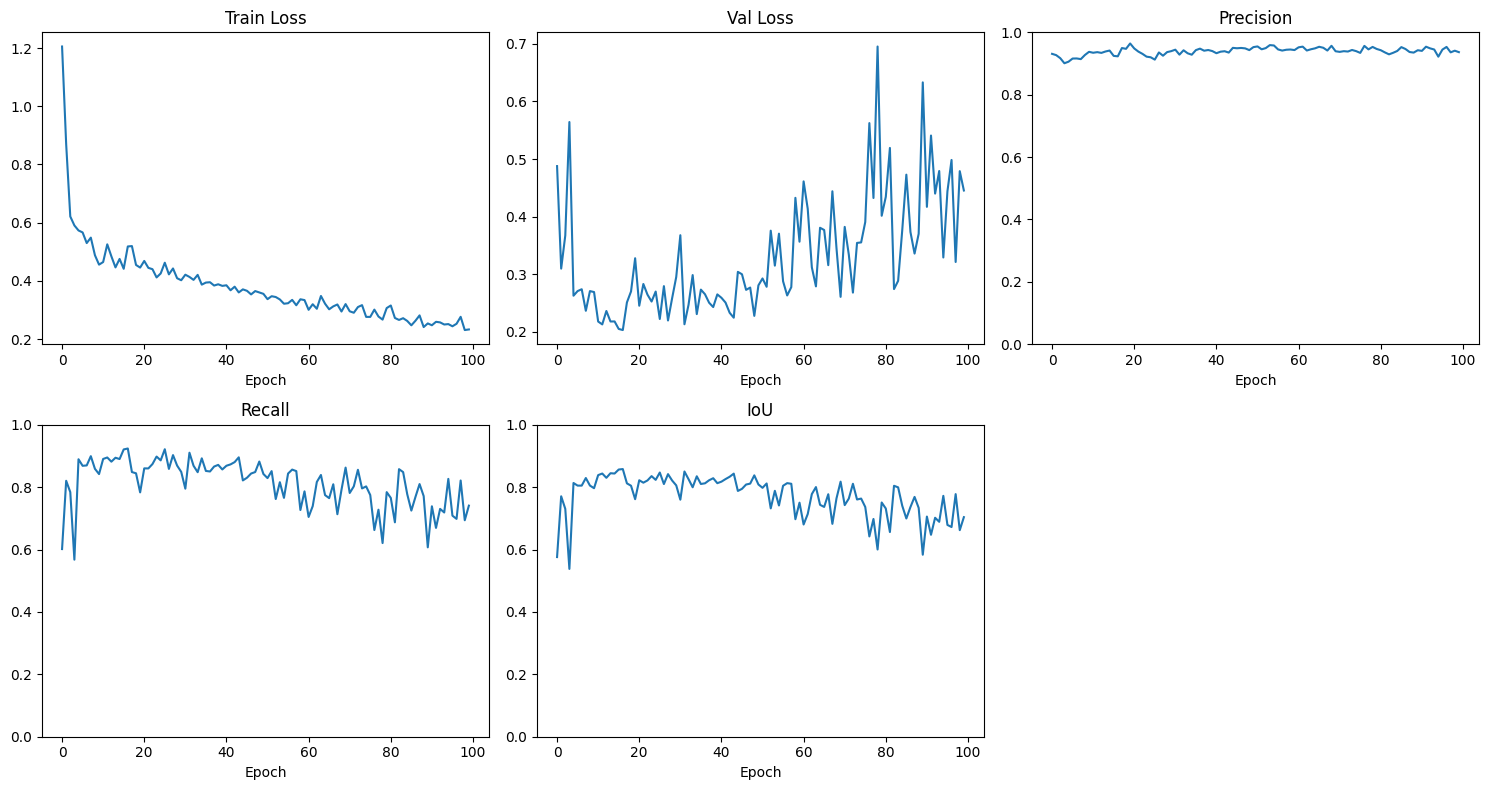

In [201]:
plot_metrics(metrics)

In [202]:
.

SyntaxError: invalid syntax (ipython-input-1933637684.py, line 1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "/content/drive/MyDrive/ColabNotebooks/models/SAM/mito_model_checkpoint.pth")

**Inference**

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [ ]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("/content/drive/MyDrive/ColabNotebooks/models/SAM/mito_full_data_10_epochs_model_checkpoint.pth"))

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, filtered_images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()


Now, let us load a new image and segment it using our trained model. NOte that we need to provide some prompt. Since we do not know where the objects are going to be we cannot supply bounding boxes. So let us provide a grid of points as our prompt.

In [ ]:
#Apply a trained model on large image
large_test_images = tifffile.imread("/content/drive/MyDrive/ColabNotebooks/data/mitochondria/small_dataset_for_training/images/12_training_mito_images.tif")
large_test_image = large_test_images[1]
patches = patchify(large_test_image, (256, 256), step=256)  #Step=256 for 256 patches means no overlap


In [ ]:
"""
input_points (torch.FloatTensor of shape (batch_size, num_points, 2)) —
Input 2D spatial points, this is used by the prompt encoder to encode the prompt.
Generally yields to much better results. The points can be obtained by passing a
list of list of list to the processor that will create corresponding torch tensors
of dimension 4. The first dimension is the image batch size, the second dimension
is the point batch size (i.e. how many segmentation masks do we want the model to
predict per input point), the third dimension is the number of points per segmentation
mask (it is possible to pass multiple points for a single mask), and the last dimension
is the x (vertical) and y (horizontal) coordinates of the point. If a different number
of points is passed either for each image, or for each mask, the processor will create
“PAD” points that will correspond to the (0, 0) coordinate, and the computation of the
embedding will be skipped for these points using the labels.

"""
# Define the size of your array
array_size = 256

# Define the size of your grid
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

In [ ]:
print(np.array(input_points).shape)

In [ ]:
patches.shape

In [ ]:
# Select a random patch for segmentation

# Compute the total number of 256x256 arrays
#num_arrays = patches.shape[0] * patches.shape[1]
# Select a random index
#index = np.random.choice(num_arrays)
# Compute the indices in the original array
#i = index // patches.shape[1]
#j = index % patches.shape[1]

#Or pick a specific patch for study.
i, j = 1, 2

# Selectelected patch for segmentation
random_array = patches[i, j]


single_patch = Image.fromarray(random_array)
# prepare image for the model

#First try without providing any prompt (no bounding box or input_points)
#inputs = processor(single_patch, return_tensors="pt")
#Now try with bounding boxes. Remember to uncomment.
inputs = processor(single_patch, input_points=input_points, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}
my_mito_model.eval()


# forward pass
with torch.no_grad():
  outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(single_patch), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(single_patch_prob)  # Assuming the second image is grayscale
axes[1].set_title("Probability Map")

# Plot the second image on the right
axes[2].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Prediction")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()